Check `https://yen-hsun.blogspot.com/2019/03/ia8-part-1-binary-image.html` for more details.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import cv2

from scipy.signal import correlate2d
from scipy.stats import bernoulli

import time
from ipywidgets import interact
from copy import deepcopy,copy

Define a binarizing function that binarizes the colors of a grey image.

In [2]:
def binarize(img, th=120):
    """
    Binarize a grey image.
    im: Grey 2D image with pixel value in (0,255)
    th: thereshold value, pixel value greater than th sets 1 and lower sets -1
    
    Return: binarized image
    """
    im = deepcopy(img)
    im[img>=th] = -1
    im[img<th] = 1
    return im.astype(np.int8)

In [3]:
# Import image as grey level
gar = cv2.imread("images/garfield.jpg", 0)
# Convert image into binary form
gar_bin = binarize(gar)
#ret,gar_bin = cv2.threshold(gar,127,255,cv2.THRESH_BINARY)

In [4]:
# Add noise to image
# The chance for sign-flip 
noise_rate = 0.4
# If the element is -1 in noise matrix, then it indicates sign-flip
noise = np.random.choice([1,-1],p=[1-noise_rate,noise_rate],size=gar.shape)
gar_noi = gar_bin*noise

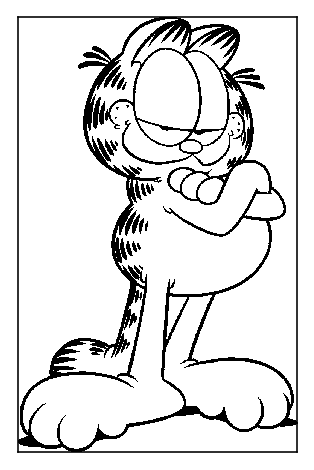

In [8]:
plt.subplot(121)
plt.imshow(gar_bin,cmap="Greys")
#plt.title("Ground truth")
plt.xticks([])
plt.yticks([])
plt.savefig("ground_truth.png",dpi=100,bbox_inches = 'tight')

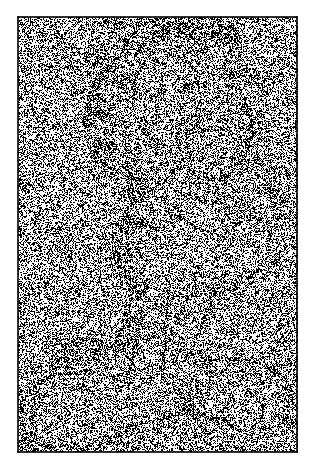

In [7]:
plt.subplot(122)
plt.imshow(gar_noi,cmap="Greys")
#plt.title("Noise with $p=%.2f$"%(noise_rate))
plt.xticks([])
plt.yticks([])
plt.savefig("noise_p4.png",dpi=100,bbox_inches = 'tight')

# 3. Algorithms for cleansing dirty image

Under the use of graphical model to cleanse a dirty image, there are two ways to achieve this. One is through *determistic algorithm* and the other is through *probabilistic algorithm*. Both rely on the regularization function, or so called energy $E$, to determine which pixel value, +1 or −1, has higher probability of appearing. The energy is given by
$$
E(x_i,y_i) = h x_i-\beta \sum_{j\in\mathcal{N}}x_i x_j -\eta x_i y_i \tag{1}
$$
where $x_i$ is the underlying true pixel value and $y_i$ is the obeserved noisy pixel. See the blog for more detail on other parameters. Thus, the conditional probability of $x_i$ and $y_i$ is
$$
P(x_i|y_i)=\frac{e^{-E(x_i,y_i)}}{\mathcal{Z}}.\tag{2}
$$
Hence, if we have $P(x_i=+1|y_i)>P(x_i=-1|y_i)$, then $x_i=+1$ is more probable than $x_i=-1$. 

## 3.1 Determistic algorithm: ICM

In [9]:
def minE(im,Epos,Eneg):
    """
    Smaller energy has definitive chance of appearing.
    """
    # Deepcopy will leave the input im untouched
    img = deepcopy(im)
    # If the elements have Epos=Eneg, they are untouched 
    img[Epos<Eneg] = 1
    img[Eneg<Epos] = -1
    return img

## 3.2 Probabilistic algorithm: Gibbs sampling

In [10]:
def gibbs(Epos,Eneg):
    """
    Smaller energy has higher probability of appearing.
    But it appears or not dependes on the result of Gibbs
    sampling.
    """
    # Calculate the probabilities for being +1 at every pixels
    pos = np.e**(-Epos)
    neg = np.e**(-Eneg)
    # Probabilities of being +1 at every pixels
    p_pos = pos/(pos+neg)
    
    # Sampling a new image according to p_pos
    # This adopts the concept of Gibbs sampling
    im = bernoulli.rvs(p=p_pos)
    # Those pixels have value 0 are actually -1
    im[im==0] = -1
    return im

# 4. Building up the `denosie` function

In [11]:
def energy(x,y,nei,params):
    """
    Energy when x = +1 or -1
    """
    beta, eta = params[0],params[1]
    return -x*beta*nei - eta*y

In [12]:
def denoise(im,y,params=[1,0.3],method="ICM"):
    """
    Binary image denoising using ICM algorithm.
    im: corrupted 2D binary image with pixel value = [1,-1]
    params: [beta,eta] = [1,0.3]
    method: ICM or Gibbs, default is ICM
    
    Return: Denoised binary image
    """
    # Contributions from neighbors
    nei = correlate2d(im,[[1,1,1], \
                          [1,0,1], \
                          [1,1,1]],\
                         mode="same")
    
    # Calculate the energies of being +1 and -1 states for every pixels
    Epos = energy(1,y,nei,params)
    Eneg = energy(-1,y,nei,params)
    
    if method == "ICM":
        return minE(im,Epos,Eneg)
    elif method == "Gibbs":
        return gibbs(Epos,Eneg)
    else:
        raise ValueError("%s is not a correct method name." % (method))

In [15]:
# ICM
iters = 25
garde_icm = deepcopy(gar_noi)
icm_seq=[gar_noi]
for i in range(iters):
    garde_icm = denoise(garde_icm,gar_noi, params=[1,0.1],method="ICM")
    icm_seq.append(garde_icm)

# Gibbs
garde_gibbs = deepcopy(gar_noi)
gibbs_seq=[gar_noi]
for i in range(iters):
    garde_gibbs = denoise(garde_gibbs,gar_noi, params=[1,0.1],method="Gibbs")
    gibbs_seq.append(deepcopy(garde_gibbs))

In general, ICM result saturated after 7-8 iterations and will not improve!

([], <a list of 0 Text yticklabel objects>)

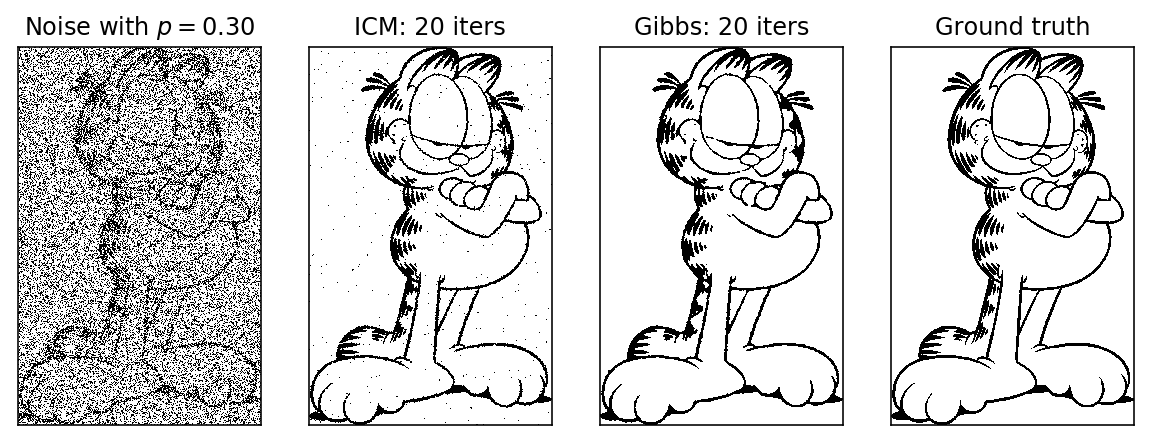

In [11]:
plt.figure(figsize=(10,5))

plt.subplot(141)
plt.imshow(gar_noi,cmap="Greys")
plt.title("Noise with $p=%.2f$"%(noise_rate))
plt.xticks([])
plt.yticks([])

plt.subplot(142)
plt.imshow(garde_icm,cmap="Greys")
plt.title("ICM: %d iters"%(iters))
plt.xticks([])
plt.yticks([])

plt.subplot(143)
plt.imshow(garde_gibbs,cmap="Greys")
plt.title("Gibbs: %d iters"%(iters))
plt.xticks([])
plt.yticks([])

plt.subplot(144)
plt.imshow(gar_bin,cmap="Greys")
plt.title("Ground truth")
plt.xticks([])
plt.yticks([])

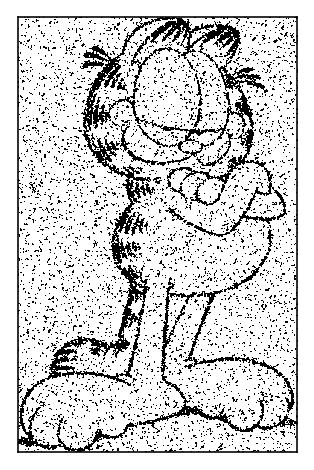

In [17]:
plt.imshow(garde_icm,cmap="Greys")
#plt.title("Ground truth")
plt.xticks([])
plt.yticks([])
plt.savefig("icm_20.png",dpi=200,bbox_inches = 'tight')

In [12]:
def draw_array(frame):
    plt.imshow(frame,cmap="Greys")
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def display_seq(images):
    def _show(frame=(0,len(images)-1)):
        return draw_array(images[frame])
    return interact(_show)

In [13]:
display_seq(icm_seq)

interactive(children=(IntSlider(value=10, description='frame', max=20), Output()), _dom_classes=('widget-inter…

<function __main__.display_seq.<locals>._show(frame=(0, 20))>

In [14]:
display_seq(gibbs_seq)

interactive(children=(IntSlider(value=10, description='frame', max=20), Output()), _dom_classes=('widget-inter…

<function __main__.display_seq.<locals>._show(frame=(0, 20))>